# RNN prediction for future value
It can predict no. of days in advance. You can configure 'future' parameter to adjust no. of days.

Adapted from https://github.com/ivanarielcaceres/timeseries-lstm-keras/blob/master/.ipynb_checkpoints/timeseries-prediction-checkpoint.ipynb

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import numpy as np

Using TensorFlow backend.


In [2]:
df = pd.read_csv('J69U.SI.csv')
print(df.head())

         Date  Open  High   Low  Close  Adj Close    Volume
0  2007-11-06  1.46  1.50  1.46   1.50   0.786575   81000.0
1  2007-11-07  1.47  1.47  1.47   1.47   0.770844    6000.0
2  2007-11-09  1.45  1.46  1.45   1.46   0.765600   24000.0
3  2007-11-12  1.45  1.45  1.38   1.40   0.734137  133000.0
4  2007-11-13  1.40  1.40  1.38   1.38   0.723649   58000.0


# Data cleansing

In [3]:
df = df[['Date','Open']]
df.set_index('Date', inplace=True)
print('Total rows: {}'.format(len(df)))
df.head()

Total rows: 2874


,Open
Date,
2007-11-06,1.46
2007-11-07,1.47
2007-11-09,1.45
2007-11-12,1.45
2007-11-13,1.40


In [4]:
df.describe()

,Open
count,2873.000000
mean,1.713013
std,0.435281
min,0.500000
25%,1.430000
50%,1.850000
75%,2.060000
max,2.410000


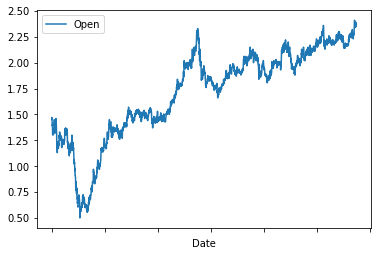

In [5]:
df.plot()

Null values?

In [6]:
df.isnull().sum()

Open    1
dtype: int64

In [7]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Open    1
dtype: int64

In [8]:
print(df[df.isnull().any(axis=1)][null_columns].head())

            Open
Date            
2008-10-27   NaN


In [9]:
df.dropna(inplace=True)

In [10]:
df.isnull().sum()

Open    0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024C7AEEA1D0>]],
      dtype=object)

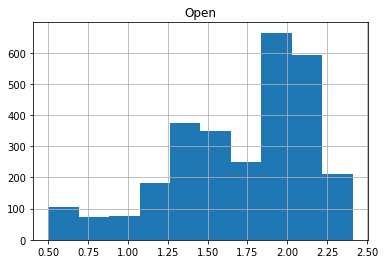

In [11]:
df.hist(bins=10)

In [12]:
len(df[df['Open'] == 0])

0

# Scaled data

In [13]:
print('Min', np.min(df))
print('Max', np.max(df))

Min Open    0.5
dtype: float64
Max Open    2.41
dtype: float64


We can then extract the NumPy array from the dataframe and convert the integer values to floating point values, which are more suitable for modeling with a neural network.

In [14]:
dataset = df.astype('float32')

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset) 

C:\Users\kohte\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [16]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


In [17]:
print(scaled[:10])

[[0.5026178 ]
 [0.5078534 ]
 [0.4973822 ]
 [0.4973822 ]
 [0.47120415]
 [0.46596856]
 [0.47120415]
 [0.42931938]
 [0.42408372]
 [0.42931938]]


# Create the RNN

A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 70% of the observations that we can use to train our model, leaving the remaining 30% for testing the model.
Split into train and test sets

In [18]:
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2011
test: 862


convert an array of values into a dataset matrix

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the energy quantity at a given time (t) and Y is the qty of energy at the next time (t + 1 + future).

In [26]:
future = 5

def create_dataset(dataset, look_back=20):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-future):
        a = dataset[i:(i+look_back), 0]
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back+future, 0])
    return np.array(dataX), np.array(dataY)

reshape into X=t and Y=t+1

In [27]:
look_back = 10
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2011 10
862 10


The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].


reshape input to be [samples, time steps, features]

In [28]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
len_train = X_train.shape[0]
len_test = X_test.shape[0]
print(X_train.shape)
print(X_test.shape)

(1995, 10, 1)
(846, 10, 1)


The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.


create and fit the LSTM network

In [29]:
def computeHCF(x, y):

# choose the smaller number
    if x > y:
        smaller = y
    else:
        smaller = x
    for i in range(1, smaller+1):
        if((x % i == 0) and (y % i == 0)):
            hcf = i
            
    return hcf
batch_size = computeHCF(len_train,len_test)
print('batch_size : {}'.format(batch_size))
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=20, batch_size=batch_size, verbose=2, shuffle=True)

batch_size : 3
Epoch 1/20
 - 15s - loss: 0.0682
Epoch 2/20
 - 15s - loss: 0.0018
Epoch 3/20
 - 14s - loss: 0.0011
Epoch 4/20
 - 14s - loss: 9.8274e-04
Epoch 5/20
 - 14s - loss: 9.2211e-04
Epoch 6/20
 - 15s - loss: 8.8604e-04
Epoch 7/20
 - 15s - loss: 8.3392e-04
Epoch 8/20
 - 14s - loss: 8.2448e-04
Epoch 9/20
 - 14s - loss: 7.9739e-04
Epoch 10/20
 - 13s - loss: 7.7601e-04
Epoch 11/20
 - 14s - loss: 7.5783e-04
Epoch 12/20
 - 15s - loss: 7.5016e-04
Epoch 13/20
 - 15s - loss: 7.3698e-04
Epoch 14/20
 - 15s - loss: 7.2550e-04
Epoch 15/20
 - 15s - loss: 7.0637e-04
Epoch 16/20
 - 15s - loss: 7.0149e-04
Epoch 17/20
 - 14s - loss: 6.8349e-04
Epoch 18/20
 - 14s - loss: 6.7831e-04
Epoch 19/20
 - 14s - loss: 6.6725e-04
Epoch 20/20
 - 13s - loss: 6.5845e-04


Make preditions

In [30]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.05 RMSE
Test Score: 0.05 RMSE


Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.


shift train predictions for plotting

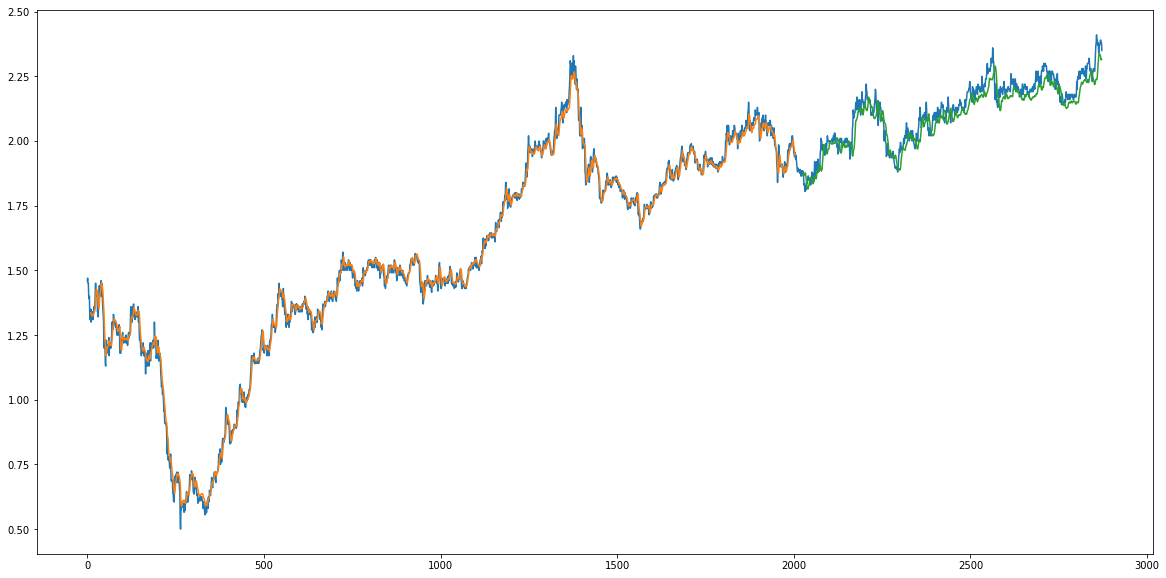

In [31]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+((look_back+future)*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()